In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
)

In [2]:
#importing packages
from ema_workbench import (
 Policy,
 ema_logging,
 MultiprocessingEvaluator,
 ScalarOutcome
)

import problem_formulation
from importlib import reload

reload(problem_formulation)  # this is used to reload the problem formulation.py so the changes made there are registered.
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(3)

import copy

#Here we print the uncertainties, levers and outcomes, to check them
for unc in dike_model.uncertainties:
 print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
for policy in dike_model.levers:
 print(repr(policy))

levers = copy.deepcopy(dike_model.levers)
for outcome in dike_model.outcomes:
 print(repr(outcome))


def get_do_nothing_dict():
 return {l.name: 0 for l in dike_model.levers}


#Here the policies for the start analysis are defined
policies = [
 Policy(
  "policy 1",  #nothing policy
  **dict(
   get_do_nothing_dict(),
  )
 ),
 Policy(
  "policy 2",  # dike increase policy
  **dict(
   get_do_nothing_dict(),
   **{"A.1_DikeIncrease 0": 5, "A.2_DikeIncrease 0": 5, "A.3_DikeIncrease 0": 5, "A.4_DikeIncrease 0": 5}
  )
 ),
 Policy(
  "policy 3",  #dike increase and room for the river policy
  **dict(
   get_do_nothing_dict(),
   **{"1_RfR 1": 1, "2_RfR 1": 1, "3_RfR 1": 1, "5_RfR 1": 1, "A.1_DikeIncrease 0": 5, "A.2_DikeIncrease 0": 5,
      "A.3_DikeIncrease 0": 5, "A.4_DikeIncrease 0": 5}
  )
 ),
]

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [19]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

experiments, outcomes = results

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
100%|██████████████████████████████████████| 3000/3000 [01:59<00:00, 25.00it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Once our results obtained, we are able to analyse them using PRIM. First however, we need to clean our dataset as to exclude categorical parameters. Those parameters, such as wave height the various RfR parameters are only integers and thus cannot be represented with a range like other parameters.

[MainProcess/INFO] 3000 points remaining, containing 750 cases of interest
[MainProcess/INFO] mean: 0.9946236559139785, mass: 0.062, coverage: 0.24666666666666667, density: 0.9946236559139785 restricted_dimensions: 5


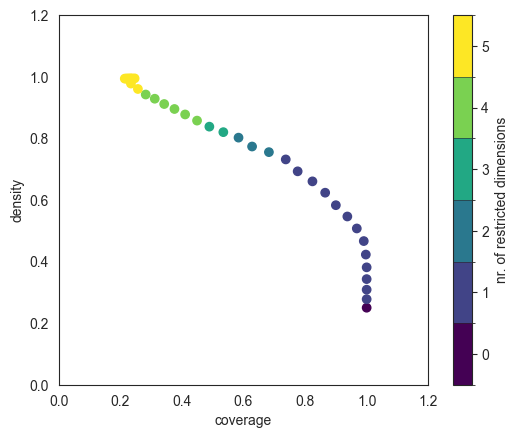

In [20]:
from ema_workbench.analysis import prim

df = pd.DataFrame(outcomes)
df_exp = pd.DataFrame(experiments)
x = df_exp[['A.1_Bmax', 'A.1_pfail', 'A.2_Bmax', 'A.2_pfail', 'A.3_Bmax', 'A.3_pfail', 'A.4_Bmax', 'A.4_pfail', 'A.5_Bmax', 'A.5_pfail']]

y = df['A.5 Total Costs']
a = y.quantile(0.75)
y = (y > a).astype(int).values


prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

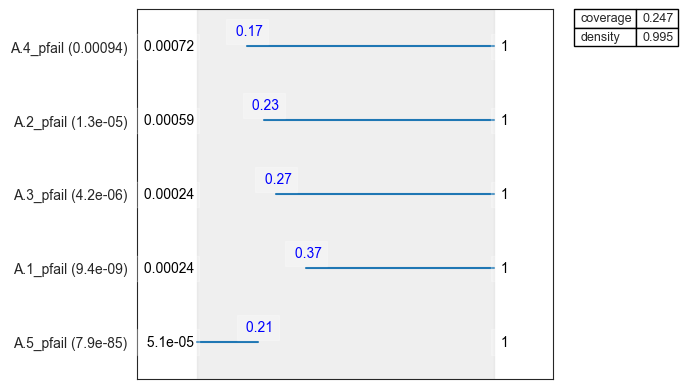

In [21]:
box1.inspect(style='graph')
plt.show()

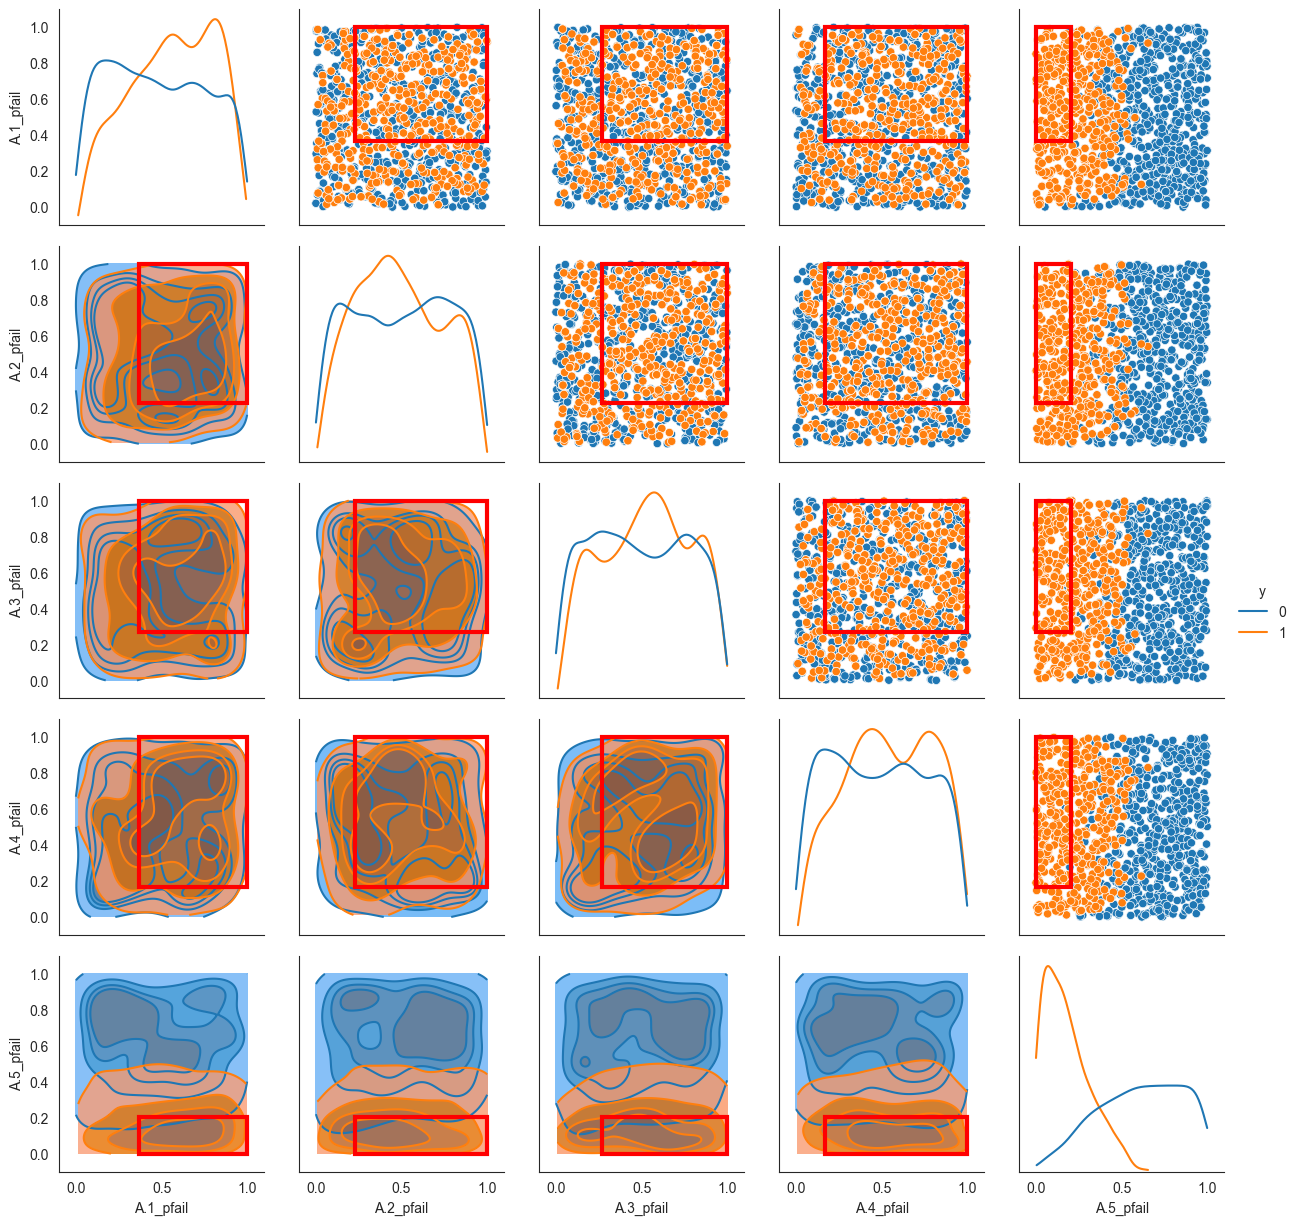

In [25]:
box1.show_pairs_scatter()
plt.show()

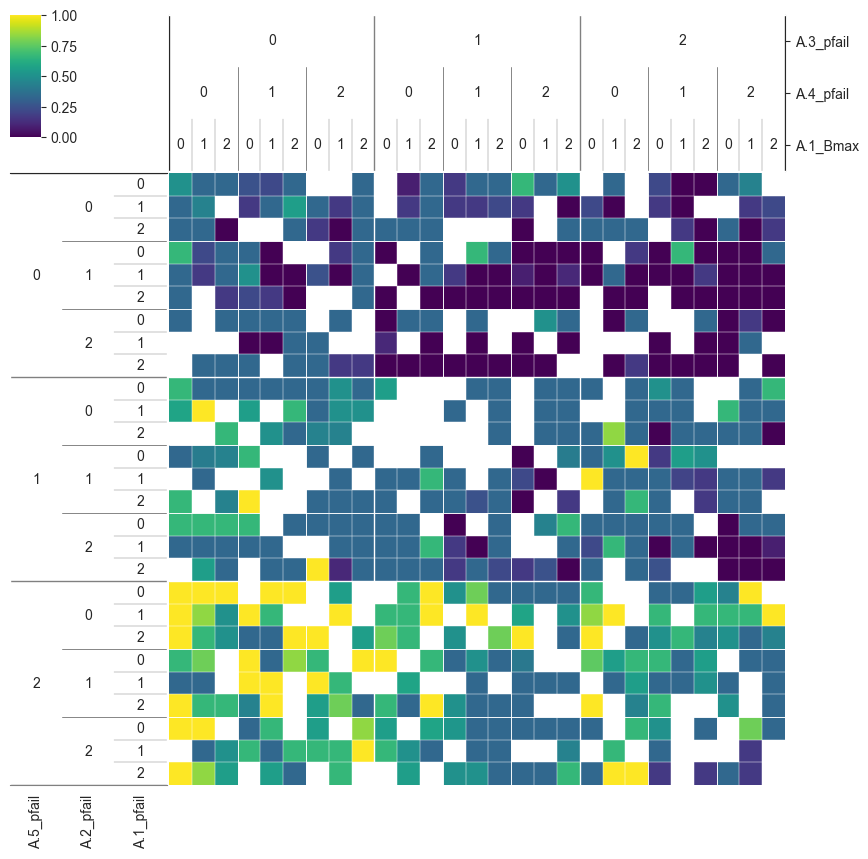

In [26]:
from ema_workbench.analysis import dimensional_stacking

x = df_exp[['A.1_Bmax', 'A.1_pfail', 'A.2_Bmax', 'A.2_pfail', 'A.3_Bmax', 'A.3_pfail', 'A.4_Bmax', 'A.4_pfail', 'A.5_Bmax', 'A.5_pfail']]
y = outcomes["A.5 Total Costs"] <  10000000
dimensional_stacking.create_pivot_plot(x, y, 3, nbins=3)
plt.show()

In [27]:
scenarios_of_interest = box1.peeling_trajectory
scenarios_of_interest = scenarios_of_interest[
    (scenarios_of_interest.coverage > 0.6) &
    (scenarios_of_interest.coverage < 0.9) &
    (scenarios_of_interest.density > 0.8)
]

In [28]:
scenarios_of_interest

,coverage,density,id,k,mass,mean,n,res_dim
